# Flexspace Customer Analysis

## Introduction

Flexspace is an on-demand workspace platform that gives companies access to real-time co-working space availability that employees can book right from their calendars. Their goal is to provide customers with the flexibility and space their employees need to thrive, and to help co-working partners easily monetize their unused perishable workspaces.

The goal of the overall analysis is to primarily focus on two groups in the data: *Operators and Customers*. This notebook will cover a Customer analysis to answer the following business questions:

- Which customers are providing more business? Who is more engaged? Why? 
- For returning customers (who ordered more than once with Flexspace): Why did they return? 
- How can we get new customers to become returning customers?
- Using an RFM analysis, who are our 'high value' customers? What makes them high value?


In [51]:
!pip install psycopg2-binary

In [52]:
import pandas as pd
import numpy as np
from sqlalchemy import engine
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [53]:
# First, I will connect to the data and create a dataframe

conn_string = r"postgresql://masterschool-analyst:pa84cc0d01e9b241460abdf838bb34f5932c9473dca571b56fcb13dd3023a62e0@ec2-52-4-84-108.compute-1.amazonaws.com:5432/da541q56oobji4"
connection = engine.create_engine(conn_string)

In [54]:
query = """select * from mat_orders"""

df = pd.read_sql(query, con=conn_string)

In [55]:
df.shape

(42129, 49)

In [56]:
# I will save the original view as a CSV to have as a backup. When the notebook runs, the CSV will be updated

df.to_csv(r'C:\Users\nguzm\OneDrive\Desktop\Data Studio\flexspace_original.csv')

## Filtering the Relevant Data

### Disclaimers
During initial exploration, the following parameters were established:

- Only look at values with the status "paid"  

- "total_price_in_usd" is the value of that order transacted through Flexspace  

- Only consider orders with the source WL or FM: The source indicates the client apps the order was made from. In the context of Flexspace Commerce, only WL and FM sources will be considered
- Exclude test users: We will ignore any full name, company name, and email containing the word "test"
- There is also a promotion code BETEST - please advise about that and other tests that we can identify ahead
- If it's a test, the value "total_price_in_usd" is usually zero (no money transacted), or the order is canceled (and refunded) with "status" as "canceled".
- Exclude/ignore taxes: this is usually transparent and we do not need to look into it
- When looking at prices consider the original price (total_price+discount), discount (in usd), and the final price (total_price)
- These fields ds_organization_id, ds_budget_id, and auth0_user_id are not related in the context of Flexspace eCommerce and can be excluded.
- Operators can be found in “partner_name”
- Customers are defined by their email as a “primary key”


In [57]:
# I will transfer the query used to create the filtered CTE in SQL here to create a subset of the relevant data for analysis.
# I will have to use %% for my ilike conditions since % is used by Python string formatting

cte_query = """
  SELECT 
    order_id, 
    partner_id AS operator_id, 
    partner_name AS operator_name, 
    status, 
    m.source, 
    fullname, 
    email AS customer_email, 
    company_name, 
    confirmation_id, 
    space_id, 
    space_name, 
    created_at, 
    promotion_code, 
    total_price AS final_price, 
    --not usd,  sub_total + tax_amount, sub_total=order_line_item_total_price
    ABS(discounted_amount) AS discounted_amount, 
    --not usd
    total_price_in_usd AS final_price_usd, 
    --amount transacted through Flexspace
    ABS(ROUND(
      discounted_amount * to_usd_rate, 2
    )) AS discounted_amount_usd, 
    ROUND(
      (
        total_price_in_usd + ABS(discounted_amount * to_usd_rate)
      ), 
      2
    ) AS original_price_usd, 
    processing_fee_in_usd, 
    to_usd_rate, 
    location_id, 
    location_name_en, 
    location_time_zone, 
    country, 
    m.state, 
    city, 
    order_line_item_id, 
    orderable_type, 
    orderable_id, 
    order_line_item_details, 
    access_id, 
    booking_product_type, 
    product_type_id, 
    add_on_days_to_expire, 
    capacity, 
    booking_id, 
    start_date, 
    end_date, 
    date, 
    quantity, 
    last_refresh 
  FROM 
    mat_orders AS m 
  WHERE 
    status = 'paid' 
    AND email NOT IN (
      SELECT 
        email 
      FROM 
        mat_orders 
      WHERE 
        1 = 1 
        AND (
          company_name ILIKE '%%test%%'
          OR fullname ILIKE '%%test%%' 
          OR email ILIKE '%%test%%' 
          OR company_name ILIKE '%%test%%' 
          OR promotion_code ILIKE '%%test%%'
        )
    ) 
    AND m.source IN ('WL', 'FM')
;

"""

filtered_df = pd.read_sql(cte_query, con=conn_string)

In [58]:
# I want to check the filtered result here to ensure the expected filtered result is produced.
# Condition status = ‘paid’ removed 17644+ rows
# Condition to exclude test users removed 273+ rows
# Condition m.source IN (‘WL’, ‘FM’) removed 945+ rows

filtered_df.shape

(23367, 41)

In [59]:
# I will also save the filtered data locally for safe keeping

df.to_csv(r'C:\Users\nguzm\OneDrive\Desktop\Data Studio\flexspace_filtered.csv')

### Sanity Checks

This section will be dedicated to performing checks on the data in order to find and address any further issues if necessary.

I will check:

- Data types of the columns in the filtered_df
- The range of time the data exists (earliest date)
- Are there any duplicate order_id's (this should be the primary key for the data)?
- General statistics for any unusual values


In [60]:
filtered_df.head()

,order_id,operator_id,operator_name,status,source,fullname,customer_email,company_name,confirmation_id,space_id,...,booking_product_type,product_type_id,add_on_days_to_expire,capacity,booking_id,start_date,end_date,date,quantity,last_refresh
0,091293e7-958f-4909-a6b5-750774f9c4c6,b6bfa6e9-e780-4b7c-af83-39a63380a709,WeWork Israel,paid,WL,Eden Sitone,Sitoneeden@gmail.com,Eden,5b0cbdf7,116b6d20-77e1-4b1e-99ff-25ca40ecd19b,...,entire_location,3ab24bff-a8c0-4773-8c12-81f2d9978f93,NaN,1.0,ee300ed9-0840-4772-86e0-52a768a4d4c0,2022-10-11,2022-10-11,None,1.0,2023-07-13 14:15:02.740939+00:00
1,c3c120c0-b08c-48fa-94f9-8cde2acd9c0b,197e925e-58c4-4b26-a533-0ef8b204cef4,Urban Place,paid,WL,Amy Stiefelmann Chaves,stiefelmannamy@gmail.com,Amy,6e5117d9,0d7cd533-1212-409c-b72b-863a384a724f,...,entire_location,3de12453-a890-4f6f-b83c-1a9f85c1dab6,NaN,1.0,529856de-fd44-4654-aa89-49e44e9fd974,2022-07-19,2022-07-19,None,1.0,2023-07-13 14:15:02.740939+00:00
2,747538d6-f817-4141-a313-ec4cc5182d99,b6bfa6e9-e780-4b7c-af83-39a63380a709,WeWork Israel,paid,WL,אורטל כהן,ortal@cl98.co.il,"נ.נ.מ אחזקות בע""מ",b3e764c9,eca6056a-62c5-435c-bbc2-6622b9c90121,...,meeting_room,d1e0ce3f-2242-466f-8f85-493f7c37553c,NaN,4.0,59de7aa2-90f3-44d3-9795-e0c8deef145c,None,None,2022-08-08,1.0,2023-07-13 14:15:02.740939+00:00
3,3458d639-1b8a-47d4-ac4c-64c9e02c9468,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Natalia Jaszczuk,reception@learnlight.com,Learnlight UK Limited,b4fa4473,954e47c2-94b3-4cd2-96c8-4b650025274b,...,entire_location,bef677a6-5596-4ca0-a31e-ea2eccb5e959,NaN,1.0,b1a50537-6cbd-407a-97e2-8e9fdd2ec7a2,2022-07-26,2022-07-26,None,1.0,2023-07-13 14:15:02.740939+00:00
4,5348084a-f50b-47e9-91cf-cfb18c7f519d,b6bfa6e9-e780-4b7c-af83-39a63380a709,WeWork Israel,paid,WL,עבדאללה סכראן,Abdalla@techub-aio.com,TecHub AiO,f005af74,9825d6b5-61d4-4045-ad47-e5aa4c31c6b4,...,entire_location,3ab24bff-a8c0-4773-8c12-81f2d9978f93,NaN,1.0,0d90ff8b-2010-4807-b57d-23f9c7fafaaa,2023-05-15,2023-05-15,None,1.0,2023-07-13 14:15:02.740939+00:00


In [61]:
# Are the data types appropriate?

filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23367 entries, 0 to 23366
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   order_id                 23367 non-null  object             
 1   operator_id              23367 non-null  object             
 2   operator_name            23367 non-null  object             
 3   status                   23367 non-null  object             
 4   source                   23367 non-null  object             
 5   fullname                 23367 non-null  object             
 6   customer_email           23367 non-null  object             
 7   company_name             23367 non-null  object             
 8   confirmation_id          23367 non-null  object             
 9   space_id                 23360 non-null  object             
 10  space_name               23360 non-null  object             
 11  created_at               233

**The data types are appropriate for now. Changes will be made if needed.**

In [62]:
# access_id can be dropped since this only contains null values

filtered_df = filtered_df.drop(['access_id'], axis=1)

filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23367 entries, 0 to 23366
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   order_id                 23367 non-null  object             
 1   operator_id              23367 non-null  object             
 2   operator_name            23367 non-null  object             
 3   status                   23367 non-null  object             
 4   source                   23367 non-null  object             
 5   fullname                 23367 non-null  object             
 6   customer_email           23367 non-null  object             
 7   company_name             23367 non-null  object             
 8   confirmation_id          23367 non-null  object             
 9   space_id                 23360 non-null  object             
 10  space_name               23360 non-null  object             
 11  created_at               233

In [63]:
# What is the earliest date in the filtered_df?

filtered_df.created_at.min()

Timestamp('2021-03-10 08:15:57.441884')

**The earliest date is Mar. 3, 2021 meaning the data spans over approx 2 years. Since 2022 is the most recent full year in the data, that will be taken into consideration.**

In [64]:
# Are there any duplicate customers?

duplicate_rows = filtered_df[filtered_df['order_id'].duplicated(keep=False)]
print(duplicate_rows)
#customers can make more than one order, and each row in the filtered_df is an order
# There are no duplicate orders

Empty DataFrame
Columns: [order_id, operator_id, operator_name, status, source, fullname, customer_email, company_name, confirmation_id, space_id, space_name, created_at, promotion_code, final_price, discounted_amount, final_price_usd, discounted_amount_usd, original_price_usd, processing_fee_in_usd, to_usd_rate, location_id, location_name_en, location_time_zone, country, state, city, order_line_item_id, orderable_type, orderable_id, order_line_item_details, booking_product_type, product_type_id, add_on_days_to_expire, capacity, booking_id, start_date, end_date, date, quantity, last_refresh]
Index: []

[0 rows x 40 columns]


In [65]:
# What are some general statistics for the monetary values in filtered_df?

filtered_df.describe()

,final_price,discounted_amount,final_price_usd,discounted_amount_usd,original_price_usd,processing_fee_in_usd,to_usd_rate,add_on_days_to_expire,capacity,quantity
count,23367.000000,23367.000000,23367.000000,23367.000000,23367.000000,23367.000000,23367.000000,3028.000000,20311.000000,23360.000000
mean,199.847814,9.797443,105.547377,4.917737,110.465114,2.830677,0.831262,48.180317,2.949978,1.183776
std,365.745986,71.141013,150.272132,31.264735,159.373806,4.315089,0.353061,23.876980,25.504666,0.697861
min,0.640000,0.000000,0.680000,0.000000,13.690000,0.000000,0.198240,30.000000,1.000000,1.000000
25%,35.000000,0.000000,34.820000,0.000000,35.000000,1.170000,0.306970,30.000000,1.000000,1.000000
50%,71.400000,0.000000,47.950000,0.000000,49.630000,1.610000,1.000000,30.000000,1.000000,1.000000
75%,175.500000,0.000000,118.240000,0.000000,120.020000,3.030000,1.043020,60.000000,1.000000,1.000000
max,9009.000000,3715.000000,3125.000000,1057.510000,3200.000000,116.300000,1.405630,180.000000,1000.000000,20.000000


#### Considerations and Observations

The **discounted_amount_usd, original_price_usd, and final_price_usd** have large maximum values, but this could be tied to orders/spaces with higher capacities. With discounts, it is likely the majority of orders/customers did not receive a discount. It will be worth looking into the distributions for these columns.

## General Customer Overview

This section will be dedicated to finding some general insights about the Flexspace customers. The following questions will be addressed and visualized if needed:

- How many distinct customers are there? Per company?
- Where are customers located? 
- What orderable_types and booking_product_types are customers ordering? What are the total order distribution counts for each type?
- Considering capacity, what is the distribution of booking_product_types?
- What is the product basket customers are purchasing? What programmatic combinations of products are being ordered by customers?
- What is the distribution of the monetary columns? Are there any outliers, or are these purchases specific to a customer or group, space, etc?


#### How many distinct customers are there?

In [66]:
# How many distinct customers are there? 

filtered_df.customer_email.nunique()

14430

#### How many distinct customers per company?

In [67]:
# How many distinct customers per company?
# Could do distribution of customers with count of companies per bin

customer_company = filtered_df[['company_name', 'customer_email']].groupby('company_name').nunique('customer_email').sort_values('customer_email', ascending=False)

customer_company = customer_company.reset_index()

#filtered_df.company_name.nunique()

customer_company.head(20)

,company_name,customer_email
0,N/A,200
1,-,106
2,Self,103
3,NA,99
4,n/a,61
5,None,52
6,Na,37
7,N/a,32
8,Private,27
9,Personal,27


#### With this many companies, it may get complicated to show the count of customers from each one. Additionally, I can see that company_name has some issues regarding the values having multiple variations (self, Self, Self-employed). These will need to be cleaned to ensure consistency in company_name. There were also some values that were in other languages. These should be considered when cleaning.

In [68]:
# I will initially clean the values by making them consitent cases

filtered_df['company_name_lower'] = filtered_df['company_name'].str.lower()

filtered_df.company_name_lower.value_counts().head(20)
#this shows the number of orders per company

n/a                        344
na                         188
self                       153
-                          148
none                        93
knowledge train             86
augury                      78
ciic pr                     60
videoamp                    53
sharethis                   49
seed                        45
hardskills gmbh             42
lookiero style uk ltd       42
synerflow b.v.              42
razroo ltd                  41
opportunity lab             41
ביי וויט בע״מ               40
studio werc ltd             39
private                     39
digital republic talent     36
Name: company_name_lower, dtype: int64

In [69]:
# I want to see how the customer counts were affected again after initial cleaning

customer_company = filtered_df[['company_name_lower', 'customer_email']].groupby('company_name_lower').nunique('customer_email').sort_values('customer_email', ascending=False).reset_index()

#customer_company = customer_company.reset_index()

#filtered_df.company_name.nunique()

customer_company.head(20)

,company_name_lower,customer_email
0,n/a,288
1,na,143
2,self,116
3,-,106
4,none,68
5,private,34
6,personal,30
7,modern health,25
8,self-employed,22
9,freelance,22


#### With many companies still, I want to instead see the distribution of companies by customer bins

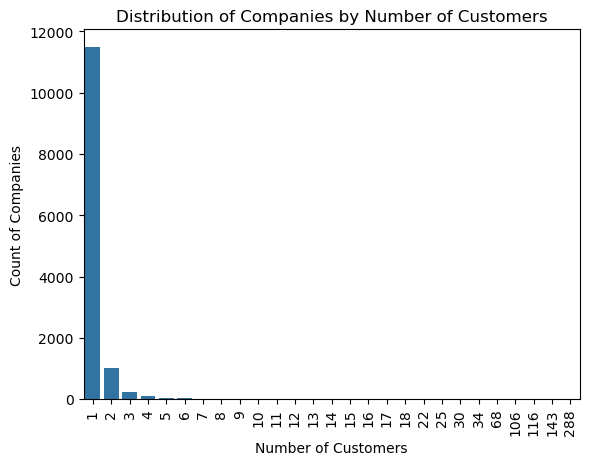

In [70]:
# Using a seaborn countplot, I can see that distribution
#create a variable for the seaborn color argument
plot_color = sns.color_palette()[0]

sns.countplot(data = customer_company, x = 'customer_email', color = plot_color).set(title='Distribution of Companies by Number of Customers', xlabel = 'Number of Customers', ylabel= 'Count of Companies');
plt.xticks(rotation=90)
plt.show()

In [71]:
# Filter the groups with only one distinct 'customer_email'
company_one_customer = customer_company[customer_company['customer_email'] == 1]

# Get the company names with only one distinct customer email
# company_names = filtered['company_name']

# Display the company names
print(company_one_customer)


                 company_name_lower  customer_email
1447   sadiq khan (individual name)               1
1448                         retama               1
1449              ruxandra arustei                1
1450                   retailsense                1
1451                   ryan mckeown               1
...                             ...             ...
12930                       hireart               1
12931                    hired guns               1
12932                     hireworks               1
12933                hireworks gmbh               1
12934               ℅ emily barasch               1

[11488 rows x 2 columns]


#### The majority of companies only have 1 customer. This could be due to the company being private, perhaps only one representative of the company being the sole user of Flexspace for a group. I will need to ensure further cleaning is done and then can look at the capacity these customers are ordering. It is likely that a private user is ordering spaces with a capacity of 1 or some small value.

In [72]:
# Further cleaining: na, self 

# Find values similar to 'self' and 'N/A'
#The pattern r'.*self.*' is a regular expression that matches any string containing the pattern 'self' anywhere within it. 
#The .* before and after 'self' means any number of characters (including zero) before and after the pattern.

similar_values = filtered_df[filtered_df['company_name_lower'].str.contains(r'.*self.*', na=False, case=False)]

#I modified the regular expression pattern to use word boundaries (\b). This ensures that the pattern is matched as a whole word

similar_values_2 = filtered_df[filtered_df['company_name_lower'].str.contains(r'\bna\b', na=False, case=False)]

#  r'\bna\b': 'n/a',
#     r'^-$': 'n/a', #exact match
#     r'\bnone\b': 'n/a',
#     r'^ $': 'n/a'
similar_values_3 = filtered_df[filtered_df['company_name_lower'].str.contains(r'^-$', na=False, case=False)]
similar_values_4 = filtered_df[filtered_df['company_name_lower'].str.contains(r'\bnone\b', na=False, case=False)]
similar_values_5 = filtered_df[filtered_df['company_name_lower'].str.contains(r'^ $', na=False, case=False)]
#two spaces
similar_values_6 = filtered_df[filtered_df['company_name_lower'].str.contains(r'^  $', na=False, case=False)]



# Get the list of similar values
similar_values_list_self = similar_values['company_name_lower'].tolist()
similar_values_list_na = similar_values_2['company_name_lower'].tolist()
similar_values_list_dash = similar_values_3['company_name_lower'].tolist()
similar_values_list_none = similar_values_4['company_name_lower'].tolist()
similar_values_list_blank = similar_values_5['company_name_lower'].tolist()
similar_values_list_2blank = similar_values_6['company_name_lower'].tolist()


# Display the list of similar values
print(similar_values_list_self)
print(len(similar_values_list_self))
print(similar_values_list_na)
print(len(similar_values_list_na))
print(similar_values_list_dash)
print(len(similar_values_list_dash))
print(similar_values_list_none)
print(len(similar_values_list_none))
print(similar_values_list_blank)
print(len(similar_values_list_blank))
print(similar_values_list_2blank)
print(len(similar_values_list_2blank))

['self-employed narek gharibyan', 'self-employed', 'self', 'myself', 'self', 'self', 'myself', 'myself', 'selfmade', 'self', 'self', 'self', 'self', 'self employer', 'bailey self', 'for self', 'self employed ', 'self', 'self employed ', 'self', 'self', 'self employed ', 'self', 'self', 'self', 'self', 'bailey self', 'self', 'self-employed', 'self', 'self', 'self', 'self', 'self', 'self-employed', 'bailey self', 'self', 'for myself', 'self', 'self', 'self', 'self', 'for myself', 'self', 'self', 'self employed', 'self employed', 'self', 'self ', 'self ', 'self', 'self employed', 'myself', 'self-employed', 'self', 'myself ', 'self', 'self', 'self', 'self', 'self', 'self-employed', 'self', 'self', 'myself', 'self ', 'self-employed', 'self', 'self', 'myself', 'self', 'self', 'self-employed', 'self', 'self', 'self', 'self', 'self', 'bailey self', 'i challenge myself', 'self', 'self employed ', 'self', 'self-employed', 'self', 'self employy', 'self employed', 'self', 'self', 'self', 'self', '

In [73]:
# 247 values contain 'self' and these are likely all self-employed. I will replace these with the same value 'self-employed'

# Replace the similar values with 'self-employed' and 'n/a'
# Define the pattern replacements
pattern_replacements = {
    r'.*self.*': 'self-employed',
    r'(?<!\bsourceability \b)\bna\b': 'n/a',
    r'^-$': 'n/a',
    r'(?<!\bbar \b)\bnone\b': 'n/a',
    r'^ $': 'n/a',
    r'^  $': 'n/a'
}

for pattern, replacement in pattern_replacements.items():
    filtered_df['company_name_lower'] = filtered_df['company_name_lower'].str.replace(pattern, replacement, regex=True)

# Value counts on company_name_lower
filtered_df.company_name_lower.value_counts().head(20)

n/a                        785
self-employed              249
knowledge train             86
augury                      78
ciic pr                     60
videoamp                    53
sharethis                   49
seed                        45
synerflow b.v.              42
lookiero style uk ltd       42
hardskills gmbh             42
razroo ltd                  41
opportunity lab             41
ביי וויט בע״מ               40
studio werc ltd             39
private                     39
beeremote inc.              36
digital republic talent     36
grafana labs                35
modern health               34
Name: company_name_lower, dtype: int64

In [74]:
#How did this affect the distribution?

customer_company = filtered_df[['company_name_lower', 'customer_email']].groupby('company_name_lower').nunique('customer_email').sort_values('customer_email', ascending=False).reset_index()

customer_company.head(20)

,company_name_lower,customer_email
0,n/a,599
1,self-employed,183
2,private,34
3,personal,30
4,modern health,25
5,freelance,22
6,gitlab,18
7,shopify,17
8,,16
9,sharethis,15


#### There are still blank values, and I will need to see how to address: private, personal, freelance (all self-employed?)

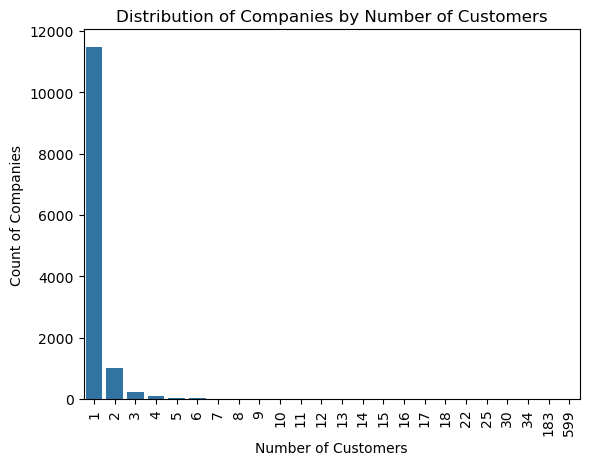

In [75]:
sns.countplot(data = customer_company, x = 'customer_email', color = plot_color).set(title='Distribution of Companies by Number of Customers', xlabel = 'Number of Customers', ylabel= 'Count of Companies');
plt.xticks(rotation=90)
plt.show()

In [76]:
#Is the number of companies with 1 customer similar?
company_one_customer = customer_company[customer_company['customer_email'] == 1]
print(company_one_customer)

                    company_name_lower  customer_email
1434                      quiet coyote               1
1435          rani dabush priority ltd               1
1436                           questdb               1
1437                   quamtaleon e.k.               1
1438                        questgiver               1
...                                ...             ...
12901  hingham institution for savings               1
12902                          hipcamp               1
12903                  hippo homes llc               1
12904                          hireart               1
12905                  ℅ emily barasch               1

[11472 rows x 2 columns]


#### The cleaning so far affected the order frequency per company since several were consolidated, but not sure if this has a huge affect on customer distribution. I will stop this exploration of companies for now and instead group customers by email domain.

#### Where are customers located?

In [77]:
# Where are customers located?

# How many countries are in the filtered data, and what frequency of orders does each have? 

filtered_df.country.value_counts()


US    9315
IL    6056
DE    4922
GB    1233
NL     958
PL     584
RO     292
Name: country, dtype: int64

In [78]:
# Are there any null values in 'country'?

filtered_df.country.isna().sum()

7

There are only 7 nulls in the country column, and these should not affect our results.

**There are 7 countries in the filtered data:**

1. US (United States)
2. IL (Israel)
3. DE (Germany)
4. GB (Great Britain/United Kingdom)
5. NL (Netherlands)
6. PL (Poland)
7. RO (Romania)

**5 countries were excluded from the original data. This could be due to low order frequencies:**

1. AU (Australia)
2. CA (Canada)
3. MX (Mexico)
4. PT (Portugal)
5. VN (Vietnam)

It could be helpful to inlcude the full names for each country for readability. 

In [79]:
# Mapping dictionary for country codes to country names
country_mapping = {'US': 'United States', 
                   'GB': 'United Kingdom', 
                   'IL': 'Israel', 
                   'NL': 'Netherlands', 
                   'PL':'Poland', 
                   'RO':'Romania',
                   'DE':'Germany'
                  }

# Create a new column with the full country names
filtered_df['country_full'] = filtered_df['country'].map(country_mapping)

# Display the DataFrame
filtered_df.head(10)

,order_id,operator_id,operator_name,status,source,fullname,customer_email,company_name,confirmation_id,space_id,...,add_on_days_to_expire,capacity,booking_id,start_date,end_date,date,quantity,last_refresh,company_name_lower,country_full
0,091293e7-958f-4909-a6b5-750774f9c4c6,b6bfa6e9-e780-4b7c-af83-39a63380a709,WeWork Israel,paid,WL,Eden Sitone,Sitoneeden@gmail.com,Eden,5b0cbdf7,116b6d20-77e1-4b1e-99ff-25ca40ecd19b,...,NaN,1.0,ee300ed9-0840-4772-86e0-52a768a4d4c0,2022-10-11,2022-10-11,None,1.0,2023-07-13 14:15:02.740939+00:00,eden,Israel
1,c3c120c0-b08c-48fa-94f9-8cde2acd9c0b,197e925e-58c4-4b26-a533-0ef8b204cef4,Urban Place,paid,WL,Amy Stiefelmann Chaves,stiefelmannamy@gmail.com,Amy,6e5117d9,0d7cd533-1212-409c-b72b-863a384a724f,...,NaN,1.0,529856de-fd44-4654-aa89-49e44e9fd974,2022-07-19,2022-07-19,None,1.0,2023-07-13 14:15:02.740939+00:00,amy,Israel
2,747538d6-f817-4141-a313-ec4cc5182d99,b6bfa6e9-e780-4b7c-af83-39a63380a709,WeWork Israel,paid,WL,אורטל כהן,ortal@cl98.co.il,"נ.נ.מ אחזקות בע""מ",b3e764c9,eca6056a-62c5-435c-bbc2-6622b9c90121,...,NaN,4.0,59de7aa2-90f3-44d3-9795-e0c8deef145c,None,None,2022-08-08,1.0,2023-07-13 14:15:02.740939+00:00,"נ.נ.מ אחזקות בע""מ",Israel
3,3458d639-1b8a-47d4-ac4c-64c9e02c9468,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Natalia Jaszczuk,reception@learnlight.com,Learnlight UK Limited,b4fa4473,954e47c2-94b3-4cd2-96c8-4b650025274b,...,NaN,1.0,b1a50537-6cbd-407a-97e2-8e9fdd2ec7a2,2022-07-26,2022-07-26,None,1.0,2023-07-13 14:15:02.740939+00:00,learnlight uk limited,United Kingdom
4,5348084a-f50b-47e9-91cf-cfb18c7f519d,b6bfa6e9-e780-4b7c-af83-39a63380a709,WeWork Israel,paid,WL,עבדאללה סכראן,Abdalla@techub-aio.com,TecHub AiO,f005af74,9825d6b5-61d4-4045-ad47-e5aa4c31c6b4,...,NaN,1.0,0d90ff8b-2010-4807-b57d-23f9c7fafaaa,2023-05-15,2023-05-15,None,1.0,2023-07-13 14:15:02.740939+00:00,techub aio,Israel
5,8735316f-d553-4c18-bb89-c5d003c9fdb4,be144f3b-6a43-44a8-8ec9-d413f380b87c,Brain Embassy,paid,WL,Karol Goreczny,Karolgoreczny@gmail.com,Karol Góreczny,b6383a58,d71ca75d-afc2-4b6b-b497-154a60159a6e,...,NaN,1.0,f905a43b-bf22-4dd0-a52c-c0e5fff26601,2022-10-14,2022-10-14,None,1.0,2023-07-13 14:15:02.740939+00:00,karol góreczny,Poland
6,fa99a4f5-5d7a-45f7-bafc-ba2edb85079b,b6bfa6e9-e780-4b7c-af83-39a63380a709,WeWork Israel,paid,WL,Yael Costi,yael@nexite.io,Nexite,8968c2ad,23669886-5e17-4022-8aa2-e450ed48cc9c,...,NaN,10.0,14cfd70f-fbb1-4e6f-a980-2a2e2bb7ac7b,None,None,2022-09-22,1.0,2023-07-13 14:15:02.740939+00:00,nexite,Israel
7,064d7d8b-23f9-40f9-bef5-31484c8602e9,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Julian Fonseca,brisbane@studiaglobaledu.com,Studia Global Education,d6264272,3299dac1-0380-448e-8b8b-07393fbef811,...,30.0,NaN,None,None,None,None,1.0,2023-07-13 14:15:02.740939+00:00,studia global education,Germany
8,6b54f049-d2cf-473c-9f20-6e0db1d4ad40,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Aaron Martin,softacroaaron@gmail.com,Soft Acrobatics,2bf30b22,345180f2-2fe4-4327-9cb2-7ff756ab8cc2,...,NaN,1.0,d5fbd0b2-54a6-44c5-8ac9-56d576a28c63,2023-04-14,2023-04-14,None,1.0,2023-07-13 14:15:02.740939+00:00,soft acrobatics,Germany
9,c3449c1f-68cf-4676-9bdf-503975c3e1c3,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Lino Gandola,lino.gandola@protonmail.com,Riceberg Ventures,683fb92a,3299dac1-0380-448e-8b8b-07393fbef811,...,NaN,1.0,e6c5a60e-c7b6-4fd6-97f5-96cb5b7aa8e2,2023-06-20,2023-06-20,None,1.0,2023-07-13 14:15:02.740939+00:00,riceberg ventures,Germany


In [80]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23367 entries, 0 to 23366
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   order_id                 23367 non-null  object             
 1   operator_id              23367 non-null  object             
 2   operator_name            23367 non-null  object             
 3   status                   23367 non-null  object             
 4   source                   23367 non-null  object             
 5   fullname                 23367 non-null  object             
 6   customer_email           23367 non-null  object             
 7   company_name             23367 non-null  object             
 8   confirmation_id          23367 non-null  object             
 9   space_id                 23360 non-null  object             
 10  space_name               23360 non-null  object             
 11  created_at               233

In [81]:
#Order frequency per country
filtered_df.country.value_counts()

US    9315
IL    6056
DE    4922
GB    1233
NL     958
PL     584
RO     292
Name: country, dtype: int64

In [82]:
# Visualize the number of customers in each of the 7 countries

customer_country = filtered_df[['country_full', 'customer_email']].groupby('country_full').nunique('customer_email').sort_values('customer_email', ascending=False)

customer_country = customer_country.reset_index()

customer_country

,country_full,customer_email
0,United States,6293
1,Israel,3364
2,Germany,2980
3,Netherlands,683
4,United Kingdom,543
5,Poland,419
6,Romania,186


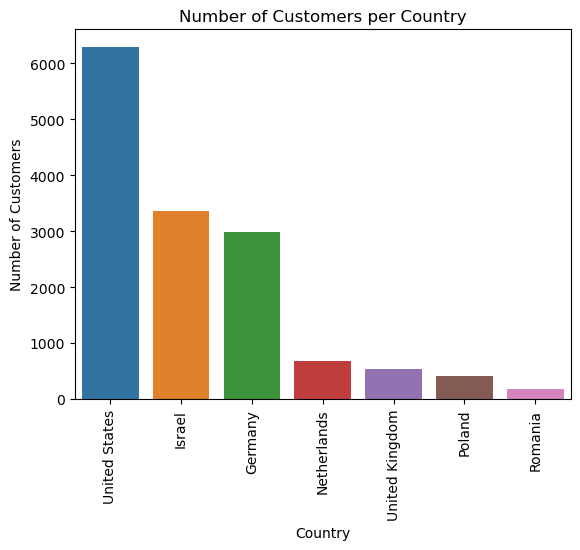

In [83]:
sns.barplot(data = customer_country, x = 'country_full', y = 'customer_email').set(title='Number of Customers per Country', xlabel='Country', ylabel='Number of Customers')
plt.xticks(rotation = 90)
plt.show;

#### The majority of customers are in the United States with approximately half that amount of customers in Israel, the second ranked country by number of customers. This will be important to keep in mind to later get an idea of where the high value and returning customers mostly reside.

- Considering capacity, what is the distribution of booking_product_types?
- What is the product basket customers are purchasing? What programmatic combinations of products are being ordered by customers?
- What is the distribution of the monetary columns? Are there any outliers, or are these purchases specific to a customer or group, space, etc?

#### What orderable_types and booking_product_types are customers ordering? What are the total order distribution counts for each type?

In [84]:
# I wrote a query in SQL to answer this question, so I will transfer it here

product_types_query = """

  WITH mat_orders_CTE AS (
  SELECT 
    order_id, 
    partner_id AS operator_id, 
    partner_name AS operator_name, 
    status, 
    m.source, 
    fullname, 
    email AS customer_email, 
    company_name, 
    confirmation_id, 
    space_id, 
    space_name, 
    created_at, 
    promotion_code, 
    total_price AS final_price, 
    --not usd,  sub_total + tax_amount, sub_total=order_line_item_total_price
    ABS(discounted_amount) AS discounted_amount, 
    --not usd
    total_price_in_usd AS final_price_usd, 
    --amount transacted through Flexspace
    ABS(ROUND(
      discounted_amount * to_usd_rate, 2
    )) AS discounted_amount_usd, 
    ROUND(
      (
        total_price_in_usd + ABS(discounted_amount * to_usd_rate)
      ), 
      2
    ) AS original_price_usd, 
    processing_fee_in_usd, 
    to_usd_rate, 
    location_id, 
    location_name_en, 
    location_time_zone, 
    country, 
    m.state, 
    city, 
    order_line_item_id, 
    orderable_type, 
    orderable_id, 
    order_line_item_details, 
    access_id, 
    booking_product_type, 
    product_type_id, 
    add_on_days_to_expire, 
    capacity, 
    booking_id, 
    start_date, 
    end_date, 
    date, 
    quantity, 
    last_refresh 
  FROM 
    mat_orders AS m 
  WHERE 
    status = 'paid' 
    AND email NOT IN (
      SELECT 
        email 
      FROM 
        mat_orders 
      WHERE 
        1 = 1 
        AND (
          company_name ILIKE '%%test%%'
          OR fullname ILIKE '%%test%%' 
          OR email ILIKE '%%test%%' 
          OR company_name ILIKE '%%test%%' 
          OR promotion_code ILIKE '%%test%%'
        )
    ) 
    AND m.source IN ('WL', 'FM')
    )

SELECT orderable_type, booking_product_type, COUNT(DISTINCT order_id) AS num_booking_product_types
FROM mat_orders_CTE
GROUP BY 1, 2
ORDER BY 3 DESC
;
"""

pd.read_sql(product_types_query, con=conn_string)

,orderable_type,booking_product_type,num_booking_product_types
0,Booking,entire_location,15796
1,Booking,meeting_room,3198
2,AddOn,access_add_on,3028
3,Booking,private_office,1317
4,AddOn,add_on,21
5,None,None,7


#### I want to see the avg capacities for these, and then the distribution of capacities per product_type to get a better understanding of what is available to the customer

In [85]:
#Product and avg capacity

product_capacity = filtered_df[['orderable_type', 'booking_product_type', 'order_id', 'customer_email', 'capacity']].groupby(['orderable_type', 'booking_product_type']).agg({'order_id':'nunique', 
                                                                                                                                                                            'customer_email':'nunique',
                                                                                                                                                                            'capacity':'mean'}).reset_index()

product_capacity

,orderable_type,booking_product_type,order_id,customer_email,capacity
0,AddOn,access_add_on,3028,1908,NaN
1,AddOn,add_on,21,18,NaN
2,Booking,entire_location,15796,10759,1.000000
3,Booking,meeting_room,3198,1929,8.474672
4,Booking,private_office,1317,779,12.922551


#### From this initial look at capacity, it seems like entire_location more often is meant for 1 person to use since the average capacity is 1. This was also seen when describe was used to get summary statistics. I want to also see the capacity distributions in general, and then for each booking orderable type. These labels are initally misleading because 'entire_location' seems to be a 1 person capacity, while 'private_office' has a much higher average.

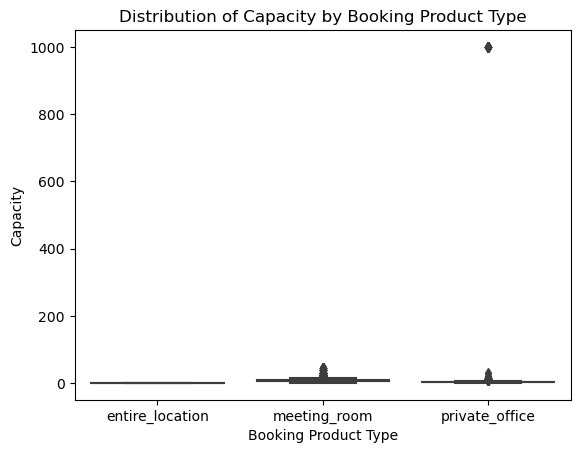

In [86]:
# filter the data to only include the 3 booking product types in Booking
booking_df = filtered_df[filtered_df['orderable_type'] == 'Booking']

# Create a boxplot of capacity for each orderable_type
sns.boxplot(data=booking_df, x='booking_product_type', y='capacity')

# Set plot title and labels
# plt.ylim(0, 50) 
plt.title('Distribution of Capacity by Booking Product Type')
plt.xlabel('Booking Product Type')
plt.ylabel('Capacity')

# Display the plot
plt.show()

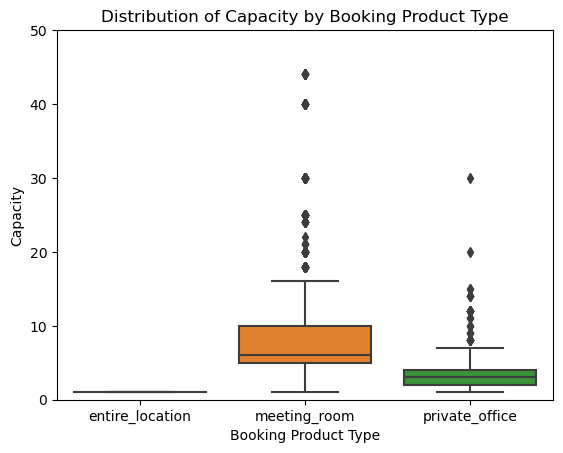

In [87]:
#Let's see the box plot excluding the higher values in private_office
sns.boxplot(data=booking_df, x='booking_product_type', y='capacity')

# Set plot title and labels
plt.ylim(0, 50) 
plt.title('Distribution of Capacity by Booking Product Type')
plt.xlabel('Booking Product Type')
plt.ylabel('Capacity')

# Display the plot
plt.show()

In [88]:
# What is the distribution of private_office?

private_office_df = filtered_df[filtered_df['booking_product_type'] == 'private_office']

#private_office_grouped = private_office_df[private_office_df['capacity']].groupby('capacity').nunique('capacity').sort_values('capacity').reset_index()

#private_office_grouped

print(private_office_df.capacity.value_counts().sort_index())


1.0       298
2.0       306
3.0       182
4.0       374
5.0        28
6.0        66
7.0         8
8.0        12
9.0         4
10.0        3
11.0        3
12.0       12
14.0        4
15.0        2
20.0        1
30.0        1
1000.0     13
Name: capacity, dtype: int64


#### There are 13 orders for private_office with a capacity of 1000. Let's see if this is the same space, and where that space is located

In [101]:
#retrieve the country, city, location_name_en, space_name, booking_product_type, capacity, num of customers, and num of orders
private_office_grouped = private_office_df[['country', 'city', 'location_name_en', 'space_name', 'booking_product_type', 'capacity', 'order_id', 'customer_email', 'final_price_usd']].groupby(['country', 'city', 'location_name_en', 'space_name', 'booking_product_type', 'capacity', 'customer_email']).agg({'order_id':'nunique', 
                                                                                                                                                                            'final_price_usd':'sum'
                                                                                                                                                                            }).reset_index()

private_office_grouped[private_office_grouped['capacity']==1000.0]

,country,city,location_name_en,space_name,booking_product_type,capacity,customer_email,order_id,final_price_usd
658,PL,Warsaw,Brain Embassy Czackiego,Day Use Office - Czackiego,private_office,1000.0,gennadii.kotulskiy@boosta.co,1,295.51
659,PL,Warsaw,Brain Embassy Jerozolimskie,Day Use Office - Jerozolimskie,private_office,1000.0,dawid@shuffle.dev,3,579.11
660,PL,Warsaw,Brain Embassy Jerozolimskie,Day Use Office - Jerozolimskie,private_office,1000.0,szymon_szczepanski@discovery.com,2,358.48
663,PL,Warsaw,Brain Embassy Konstruktorska,Day Use Office - Konstruktorska,private_office,1000.0,eliza.grabek@poccofinance.com,2,440.27
664,PL,Warsaw,Brain Embassy Konstruktorska,Day Use Office - Konstruktorska,private_office,1000.0,jan.hartmann@highcat.io,1,188.51
667,PL,Warsaw,Brain Embassy Postępu,Day Use Office - Postępu,private_office,1000.0,adziewulska@apptension.com,1,226.27
668,PL,Warsaw,Brain Embassy Postępu,Day Use Office - Postępu,private_office,1000.0,christian.kurze@mongodb.com,1,153.25
669,PL,Warsaw,Brain Embassy Postępu,Day Use Office - Postępu,private_office,1000.0,lukasz.lukasiewicz1602@gmail.com,1,148.35
670,PL,Warsaw,Brain Embassy Postępu,Day Use Office - Postępu,private_office,1000.0,natalia@prudenspdp.pl,1,135.21


#### The space with 1000 capacity is a private_office product_type, day_use, and is located in Warsaw, Poland named the "Brain Embassy." Though, this is not where we see the higher final prices as assumed. 

In [108]:
# Orders with the highest prices

sorted_filtered_df = filtered_df.sort_values('final_price_usd', ascending=False)

sorted_filtered_df[['operator_name', 'customer_email','date', 'country_full', 'location_name_en', 'space_name', 'capacity', 'orderable_type', 'booking_product_type', 'start_date', 'end_date', 'final_price_usd']].head(20)

,operator_name,customer_email,date,country_full,location_name_en,space_name,capacity,orderable_type,booking_product_type,start_date,end_date,final_price_usd
18262,The Malin,jamiece.larrymore@veja.fr,2023-04-19,United States,The Malin Willamsburg,The Bedford Library,20.0,Booking,meeting_room,None,None,3125.00
6818,The Malin,nalima.toure@gmail.com,2023-04-28,United States,The Malin SOHO,The Mercer Library,25.0,Booking,meeting_room,None,None,3000.00
32,The Malin,earthtoteng@gmail.com,2022-09-08,United States,The Malin SOHO,The Mercer Library,25.0,Booking,meeting_room,None,None,3000.00
4594,Werqwise,anand@acalvio.com,None,United States,Werqwise San Francisco,Werqwise Office Day Pass - 8p,8.0,Booking,private_office,2023-04-24,2023-04-27,2880.00
2441,The Yard,anxhelinaprenika@litworld.org,None,United States,The Yard: Flatiron North,The Yard Day Pass,NaN,AddOn,add_on,None,None,2880.00
16400,The Yard,renee@lesecologycenter.org,None,United States,The Yard: Lower East Side,The Yard Day Pass,NaN,AddOn,add_on,None,None,2880.00
16543,WeWork Israel,or@urbanstory.club,2023-01-05,Israel,WeWork ToHa,Classroom H,44.0,Booking,meeting_room,None,None,2600.97
1314,WeWork Israel,office@evinced.com,None,Israel,WeWork ToHa,Daily Office - 9p with window,9.0,Booking,private_office,2022-07-17,2022-07-21,2478.52
10922,The Malin,erica.goldberg@skinfix.com,2023-07-13,United States,The Malin SOHO,The Spring Room,16.0,Booking,meeting_room,None,None,2200.00
16601,The Malin,erica.gael@gmail.com,2023-07-12,United States,The Malin SOHO,The Spring Room,16.0,Booking,meeting_room,None,None,2200.00


#### Capacity does not seem to have a correlation to final price, though it seems more correlated to the number of days the space was used. This could be investigated when trying to assess what makes the produce "sticky" for returning customers (if enough data available for the start and end date).

#### I also want to verify that entire_location only has a capacity of 1 according to the box plot distribution seen above.

In [90]:
entire_location_df = filtered_df[filtered_df['booking_product_type'] == 'entire_location']


print(entire_location_df.capacity.value_counts().sort_index())

1.0    15796
Name: capacity, dtype: int64


#### What is the product basket customers are purchasing? What programmatic combinations of products are being ordered by customers?


In [91]:
#Without considering programmatic combinations, below is a SQL query that shows products each customer has purchased

product_basket_query = """
WITH mat_orders_CTE AS (
  SELECT 
    order_id, 
    partner_id AS operator_id, 
    partner_name AS operator_name, 
    status, 
    m.source, 
    fullname, 
    email AS customer_email, 
    company_name, 
    confirmation_id, 
    space_id, 
    space_name, 
    created_at, 
    promotion_code, 
    total_price AS final_price, 
    --not usd,  sub_total + tax_amount, sub_total=order_line_item_total_price
    ABS(discounted_amount) AS discounted_amount, 
    --not usd
    total_price_in_usd AS final_price_usd, 
    --amount transacted through Flexspace
    ABS(ROUND(
      discounted_amount * to_usd_rate, 2
    )) AS discounted_amount_usd, 
    ROUND(
      (
        total_price_in_usd + ABS(discounted_amount * to_usd_rate)
      ), 
      2
    ) AS original_price_usd, 
    processing_fee_in_usd, 
    to_usd_rate, 
    location_id, 
    location_name_en, 
    location_time_zone, 
    country, 
    m.state, 
    city, 
    order_line_item_id, 
    orderable_type, 
    orderable_id, 
    order_line_item_details, 
    access_id, 
    booking_product_type, 
    product_type_id, 
    add_on_days_to_expire, 
    capacity, 
    booking_id, 
    start_date, 
    end_date, 
    date, 
    quantity, 
    last_refresh 
  FROM 
    mat_orders AS m 
  WHERE 
    status = 'paid' 
    AND email NOT IN (
      SELECT 
        email 
      FROM 
        mat_orders 
      WHERE 
        1 = 1 
        AND (
          company_name ILIKE '%%test%%'
          OR fullname ILIKE '%%test%%' 
          OR email ILIKE '%%test%%' 
          OR company_name ILIKE '%%test%%' 
          OR promotion_code ILIKE '%%test%%'
        )
    ) 
    AND m.source IN ('WL', 'FM')
    )
,
customer_products AS (
 SELECT customer_email AS customer, 
 booking_product_type, 
 CASE WHEN booking_product_type = 'entire_location' THEN COUNT(*) ELSE 0 END AS num_entire_location,
 CASE WHEN booking_product_type = 'meeting_room' THEN COUNT(*) ELSE 0 END AS num_meeting_room,
 CASE WHEN booking_product_type = 'access_add_on' THEN COUNT(*) ELSE 0 END AS num_access_add_on,
 CASE WHEN booking_product_type = 'private_office' THEN COUNT(*) ELSE 0 END AS num_private_office,
 CASE WHEN booking_product_type = 'add_on' THEN COUNT(*) ELSE 0 END AS num_add_on,
 COUNT(DISTINCT order_id) AS num_orders
 FROM mat_orders_CTE AS m
 GROUP BY 1, 2
 )
 ,

 product_basket AS (

 SELECT customer,
 	STRING_AGG(DISTINCT booking_product_type, ', ') AS product_type_ordered,
 	COUNT(booking_product_type) AS num_product_type,
 	SUM(num_entire_location) AS total_entire_location,
 	SUM(num_meeting_room) AS total_meeting_room,
 	SUM(num_access_add_on) AS total_access_add_on,
 	SUM(num_private_office) AS total_private_office,
    SUM(num_add_on) AS total_add_on,
 	SUM(num_orders) AS total_orders
 FROM customer_products AS c
 GROUP BY 1
 ORDER BY 9 DESC)

 SELECT *
 FROM product_basket;"""

product_basket = pd.read_sql(product_basket_query, con=conn_string)

product_basket

,customer,product_type_ordered,num_product_type,total_entire_location,total_meeting_room,total_access_add_on,total_private_office,total_add_on,total_orders
0,sgrossman@augury.com,"entire_location, meeting_room, private_office",3,7.0,69.0,0.0,2.0,0.0,80.0
1,ohr@buywith.com,"entire_location, meeting_room, private_office",3,6.0,3.0,0.0,33.0,0.0,42.0
2,charlie@razroo.com,"entire_location, private_office",2,3.0,0.0,0.0,39.0,0.0,42.0
3,gabriel@beeremote.co,"entire_location, meeting_room",2,33.0,8.0,0.0,0.0,0.0,41.0
4,rob@studiowerc.com,entire_location,1,41.0,0.0,0.0,0.0,0.0,41.0
...,...,...,...,...,...,...,...,...,...
14425,georg@thespacebetween.at,entire_location,1,1.0,0.0,0.0,0.0,0.0,1.0
14426,georg.wolf@me.com,entire_location,1,1.0,0.0,0.0,0.0,0.0,1.0
14427,geostik@gmail.com,access_add_on,1,0.0,0.0,1.0,0.0,0.0,1.0
14428,geraldmaier84@gmail.com,entire_location,1,1.0,0.0,0.0,0.0,0.0,1.0


In [92]:
product_basket.product_type_ordered.value_counts()
#frequency per product

entire_location                                                 9930
meeting_room                                                    1698
access_add_on                                                   1276
private_office                                                   611
access_add_on, entire_location                                   544
entire_location, meeting_room                                    129
entire_location, private_office                                   91
meeting_room, private_office                                      32
access_add_on, entire_location, meeting_room                      31
access_add_on, meeting_room                                       23
access_add_on, private_office                                     16
access_add_on, entire_location, private_office                    15
entire_location, meeting_room, private_office                     12
add_on                                                            12
add_on, entire_location           

#### The majority of products ordered were single booking products for entire locations and meeting rooms, followed by access add ons.

#### What is the distribution of the monetary columns? Are there any outliers, or are these purchases specific to a customer or group, space, etc?


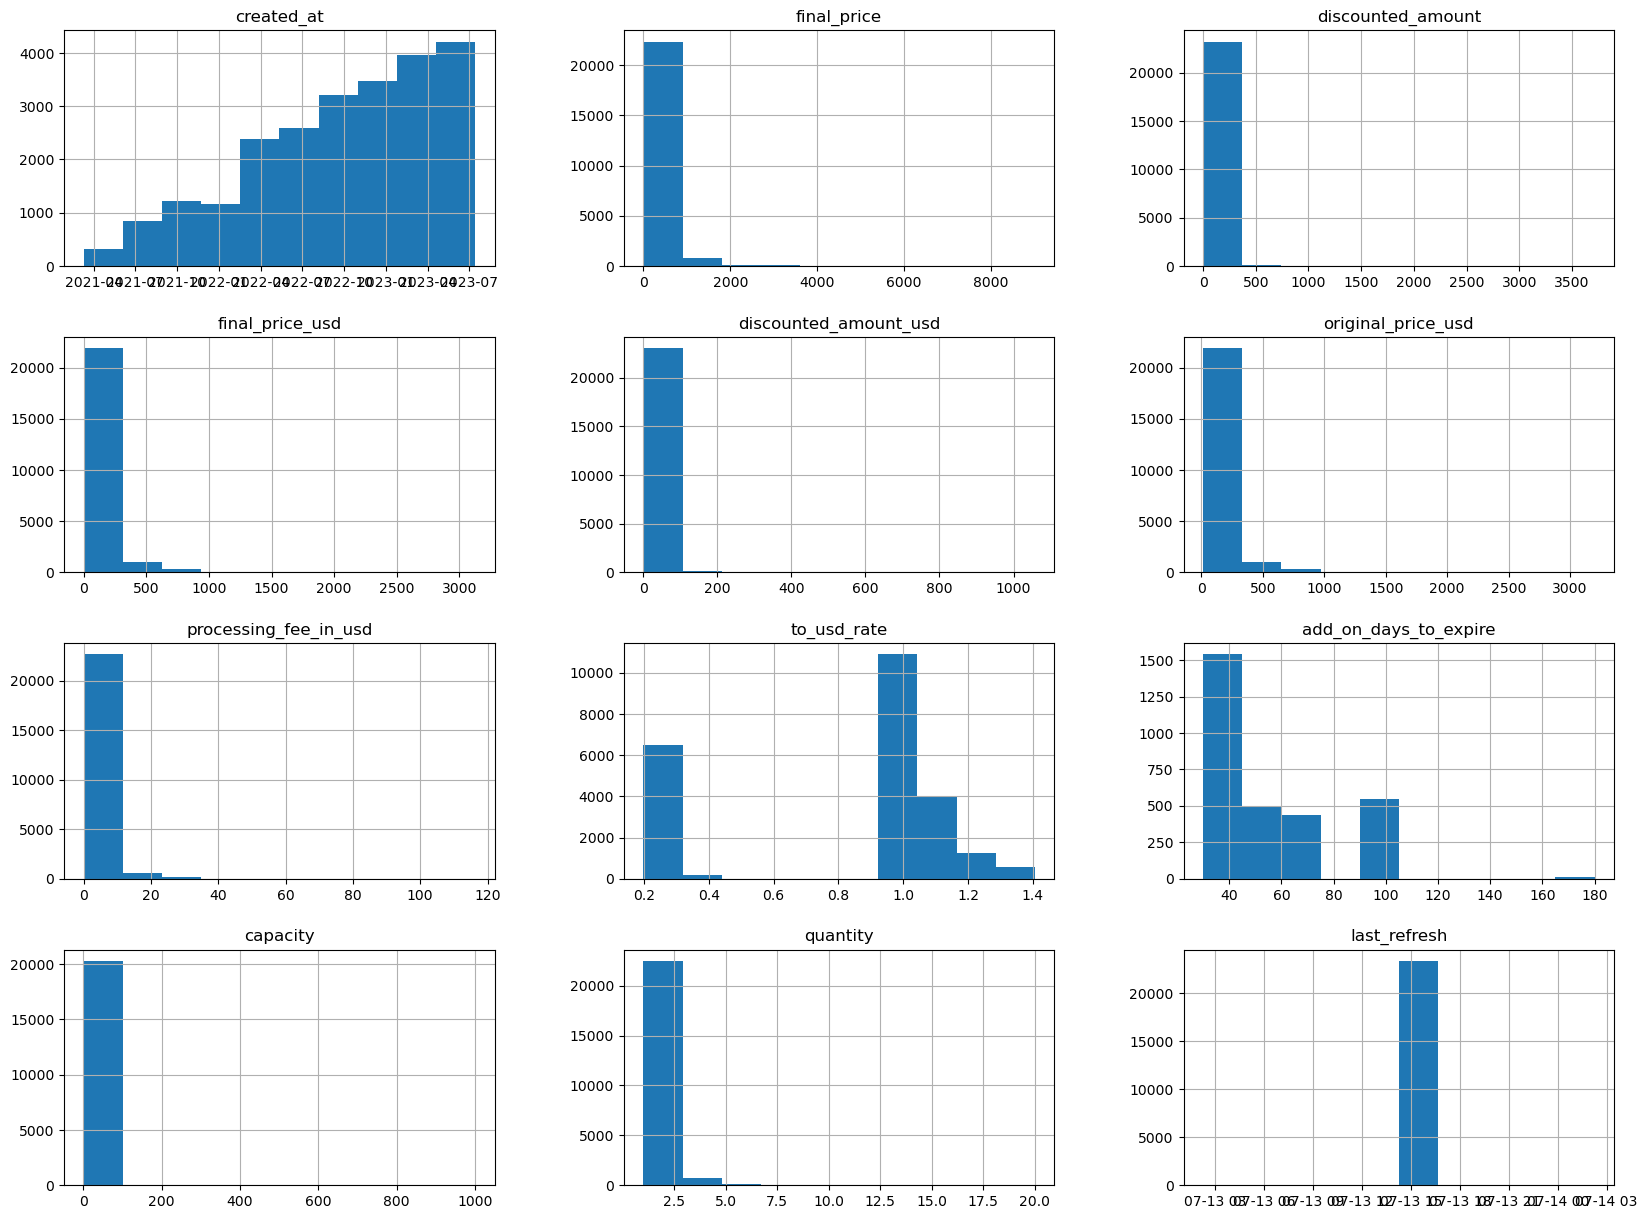

In [93]:
filtered_df.hist(figsize=(20,15));

## Customer Deep-Dive

- RFM for customers and Employ the same process of cluttering
	1. Maximum transaction date for each customer (recency)
    2. Order count for each customer (frequency, counting 2 orders in the same day as 1)
    3. Sum of final price for each customer (monetary value)
    4. Lifetime of customer: last -first in days
    5. Average interval - lifetime in days/number of orders(frequency) 
    6. Lifetime Value per Customer
    
    
- Second order analysis: returning customers, why did they return? Where did they return (location, space)? 
- Second Order Matrix: compare returning customer's first order to second order to see why returning? Discount? What is the interval between orders?


### RFM Analysis

In [94]:
#RFM 2022, and past 6 months
#Returning customers - diff with avg, discount, 

In [160]:
"""For the RFM, I want to inlcude
1. Maximum transaction date for each customer (recency)
2. Order count for each customer (frequency, counting 2 orders in the same day as 1)
3. Sum of final price for each customer (monetary value)
4. Lifetime of customer: last -first in days
5. Average interval - lifetime in days/number of orders(frequency) 
"""

#I want to start with a basic rfm, then build from there

rfm_df = filtered_df.loc[:, ['customer_email', 'order_id', 'created_at', 'final_price_usd']]
rfm_df['created_at'] = rfm_df.created_at.dt.date

# Instead of counting the order_id which will be distinct for orders happening on the same day, I will do a unique count of created_at dates per customer
frequency_rfm = rfm_df.groupby('customer_email')['created_at'].nunique().reset_index()


frequency_rfm

,customer_email,created_at
0,0488875@gmail.com,3
1,0524235148si@gmail.com,1
2,052kozoz@gmail.com,3
3,0584854855yos@gmail.com,1
4,0585171281@proton.me,1
...,...,...
14425,zviherzig@gmail.com,2
14426,zvikac@baseline.co.il,1
14427,zwilliams@figma.com,1
14428,zyamagin@gmail.com,2


In [161]:
rfm_df = filtered_df.groupby(['customer_email']).agg({'created_at':'max',
                                                      'final_price_usd':'sum'
                                                     }).reset_index()




rfm_df['recency'] = (pd.to_datetime('today') - rfm_df['created_at']).dt.days
rfm_df.drop('created_at', axis=1, inplace=True)
#rfm_df['created_at'] = rfm_df.created_at.dt.date

rfm_df.rename(columns={'final_price_usd': 'monetary_value'}, inplace=True)


rfm_df

,customer_email,monetary_value,recency
0,0488875@gmail.com,76.21,51
1,0524235148si@gmail.com,40.85,212
2,052kozoz@gmail.com,132.84,161
3,0584854855yos@gmail.com,120.08,198
4,0585171281@proton.me,30.90,381
...,...,...,...
14425,zviherzig@gmail.com,76.81,155
14426,zvikac@baseline.co.il,34.46,7
14427,zwilliams@figma.com,63.22,412
14428,zyamagin@gmail.com,143.79,144


In [162]:
# Need to merge frequency_rfm
# I now want to add features: lifetime and avg interval
# Here I will add lifetime to the RFM

min_max_created_at = filtered_df.groupby('customer_email')['created_at'].agg(['min', 'max']).reset_index()
min_max_created_at.columns = ['customer_email', 'created_at_min', 'created_at_max']

# Merge min_max_created_at and frequency_rfm with rfm_df
rfm_df = rfm_df.merge(frequency_rfm, on='customer_email')
rfm_df = rfm_df.merge(min_max_created_at, on='customer_email')

# Calculate the lifetime in days
rfm_df['lifetime_days'] = (rfm_df['created_at_max'] - rfm_df['created_at_min']).dt.days
rfm_df['created_at_max'] = rfm_df.created_at_max.dt.date
rfm_df['created_at_min'] = rfm_df.created_at_min.dt.date

rfm_df.rename(columns={'created_at': 'frequency'}, inplace=True)

# Updated RFM DataFrame
rfm_df

,customer_email,monetary_value,recency,frequency,created_at_min,created_at_max,lifetime_days
0,0488875@gmail.com,76.21,51,3,2023-05-04,2023-05-23,19
1,0524235148si@gmail.com,40.85,212,1,2022-12-12,2022-12-12,0
2,052kozoz@gmail.com,132.84,161,3,2022-12-08,2023-02-02,55
3,0584854855yos@gmail.com,120.08,198,1,2022-12-27,2022-12-27,0
4,0585171281@proton.me,30.90,381,1,2022-06-27,2022-06-27,0
...,...,...,...,...,...,...,...
14425,zviherzig@gmail.com,76.81,155,2,2023-02-06,2023-02-07,0
14426,zvikac@baseline.co.il,34.46,7,1,2023-07-06,2023-07-06,0
14427,zwilliams@figma.com,63.22,412,1,2022-05-27,2022-05-27,0
14428,zyamagin@gmail.com,143.79,144,2,2023-02-09,2023-02-19,9


In [163]:
#Here I will add the average interval between orders per customer

#I will sort the dates by customer, and then use .shift to perform a sort of lag operation on the dates
sorted_date = filtered_df[['customer_email', 'created_at']].sort_values(by=['customer_email', 'created_at'], ascending=[True, True], ignore_index=True)

sorted_date['created_at']=sorted_date['created_at'].dt.date


sorted_date['previous_order'] = sorted_date.groupby(['customer_email'])['created_at'].shift()

# From this, days between visits is simply the difference:
sorted_date['interval_days'] = sorted_date['created_at'] - sorted_date['previous_order']


# To calculate mean, convert the date delta object to days:
sorted_date['interval_days'] = sorted_date['interval_days'].apply(lambda x: x.days)


# df['days_bw_visits'].mean()

sorted_date

,customer_email,created_at,previous_order,interval_days
0,0488875@gmail.com,2023-05-04,NaN,NaN
1,0488875@gmail.com,2023-05-18,2023-05-04,14.0
2,0488875@gmail.com,2023-05-23,2023-05-18,5.0
3,0524235148si@gmail.com,2022-12-12,NaN,NaN
4,052kozoz@gmail.com,2022-12-08,NaN,NaN
...,...,...,...,...
23362,zvikac@baseline.co.il,2023-07-06,NaN,NaN
23363,zwilliams@figma.com,2022-05-27,NaN,NaN
23364,zyamagin@gmail.com,2023-02-09,NaN,NaN
23365,zyamagin@gmail.com,2023-02-19,2023-02-09,10.0


In [164]:
# Average days between visits:
avg_interval_df = sorted_date.groupby('customer_email')['interval_days'].mean().reset_index()
avg_interval_df.columns = ['customer_email', 'avg_interval_days']


avg_interval_df

,customer_email,avg_interval_days
0,0488875@gmail.com,9.5
1,0524235148si@gmail.com,NaN
2,052kozoz@gmail.com,28.0
3,0584854855yos@gmail.com,NaN
4,0585171281@proton.me,NaN
...,...,...
14425,zviherzig@gmail.com,1.0
14426,zvikac@baseline.co.il,NaN
14427,zwilliams@figma.com,NaN
14428,zyamagin@gmail.com,10.0


In [165]:
# Merge avg_interval_df with rfm_df
rfm_df = rfm_df.merge(avg_interval_df, on='customer_email')

rfm_df

,customer_email,monetary_value,recency,frequency,created_at_min,created_at_max,lifetime_days,avg_interval_days
0,0488875@gmail.com,76.21,51,3,2023-05-04,2023-05-23,19,9.5
1,0524235148si@gmail.com,40.85,212,1,2022-12-12,2022-12-12,0,NaN
2,052kozoz@gmail.com,132.84,161,3,2022-12-08,2023-02-02,55,28.0
3,0584854855yos@gmail.com,120.08,198,1,2022-12-27,2022-12-27,0,NaN
4,0585171281@proton.me,30.90,381,1,2022-06-27,2022-06-27,0,NaN
...,...,...,...,...,...,...,...,...
14425,zviherzig@gmail.com,76.81,155,2,2023-02-06,2023-02-07,0,1.0
14426,zvikac@baseline.co.il,34.46,7,1,2023-07-06,2023-07-06,0,NaN
14427,zwilliams@figma.com,63.22,412,1,2022-05-27,2022-05-27,0,NaN
14428,zyamagin@gmail.com,143.79,144,2,2023-02-09,2023-02-19,9,10.0


In [166]:
# # I want to only show the relevant fields, but I will create a copy to do so if changes are needed

# rfm_df_1 = rfm_df.copy()

# #rfm_df_1 = rfm_df_1.drop(['created_at_min', 'created_at_max'], axis=1)

# rfm_df_1